## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file
f = open('complaints-2021-05-14_08_16.json')# Write the path to your data file and load it

# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
# shape of the dataframe
df.shape

(78313, 22)

In [5]:
#print the column names
df.columns


Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [6]:
#Assign new column names

# Selecting only the required columns
df = df[['_source.complaint_what_happened','_source.product','_source.sub_product',]]

# Renaming columns for better readability
df.rename(columns={"_source.complaint_what_happened": "complaint_text",
                   "_source.product": "product",
                   "_source.sub_product": "sub_product"}, inplace=True)

df.head()

,complaint_text,product,sub_product
0,,Debt collection,Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card


In [7]:
#Assign nan in place of blanks in the complaints column
df['complaint_text'] = df['complaint_text'].replace('', np.nan)



In [8]:
#Remove all rows where complaints column is nan
df = df[df['complaint_text'].notna()]

df.complaint_text.isnull().sum()

df.head()


,complaint_text,product,sub_product
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o...",Other personal consumer report
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o...",Credit reporting
14,my grand son give me check for {$1600.00} i de...,Checking or savings account,Checking account


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [9]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    # Make text lowercase
    text = text.lower()
    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    return text.strip()

In [10]:
df['cleaned_text'] = df['complaint_text'].apply(clean_text)
df.head()


,complaint_text,product,sub_product,cleaned_text
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt,good morning my name is xxxx xxxx and i apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card,i upgraded my xxxx xxxx card in xxxx and was t...
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o...",Other personal consumer report,chase card was reported on xxxx however fraudu...
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o...",Credit reporting,on xxxx while trying to book a xxxx xxxx tic...
14,my grand son give me check for {$1600.00} i de...,Checking or savings account,Checking account,my grand son give me check for i deposit it i...


In [11]:
#Write your function to Lemmatize the texts
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    # Lemmatize each token in the text
    lemmatized_text = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_text)


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rishabhsaha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
%%time
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints

# Apply the lemmatization function to the cleaned text
df['lemmatized_complaints'] = df['cleaned_text'].apply(lemmatize_text)

CPU times: user 21.6 s, sys: 160 ms, total: 21.7 s
Wall time: 21.8 s


In [13]:
df_clean = df[['complaint_text', 'lemmatized_complaints']]
df_clean.head()

,complaint_text,lemmatized_complaints
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in xxxx and wa to...
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on xxxx however fraudul...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xxxx while trying to book a xxxx xxxx ticke...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...


In [14]:
%%time
#Write your function to extract the POS tags
nlp = spacy.load("en_core_web_sm")
def pos_tag(text):
  # write your code here
  doc = nlp(text)
  sent = [token.text for token in doc if token.tag_ == 'NN']
  return ' '.join(sent)

df_clean["complaint_POS_removed"] = df_clean["lemmatized_complaints"].apply(pos_tag)


CPU times: user 18min 8s, sys: 22.7 s, total: 18min 30s
Wall time: 21min 51s


<timed exec>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [15]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaint_text,lemmatized_complaints,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop debt verification statement ...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in xxxx and wa to...,card agent anniversary date agent wa informati...
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on xxxx however fraudul...,card application identity consent service cred...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xxxx while trying to book a xxxx xxxx ticke...,ticket offer ticket reward card information of...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




/var/folders/7d/_tknpwq147sc6bnrbrx98d6c0000gn/T/ipykernel_99174/1334622774.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



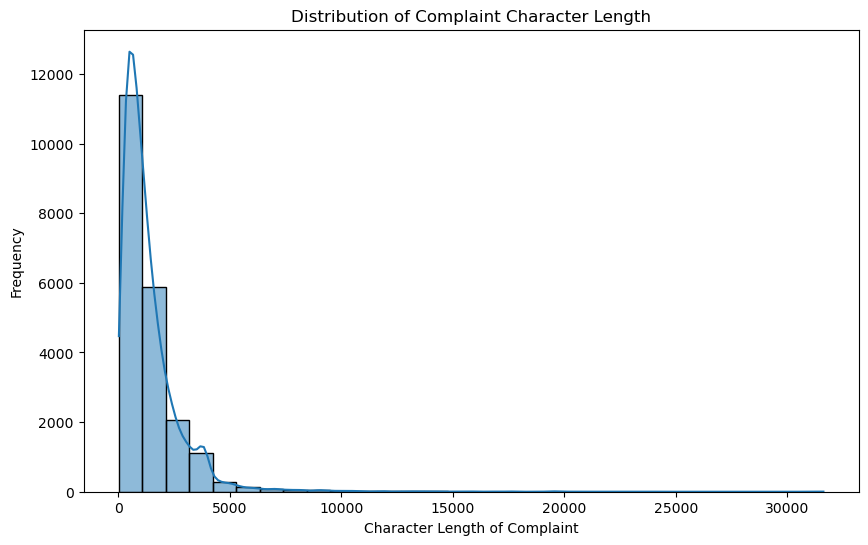

In [16]:
# Write your code here to visualise the data according to the 'Complaint' character length

df_clean['complaint_length'] = df_clean['complaint_text'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(df_clean['complaint_length'], bins=30, kde=True)
plt.title('Distribution of Complaint Character Length')
plt.xlabel('Character Length of Complaint')
plt.ylabel('Frequency')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [17]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


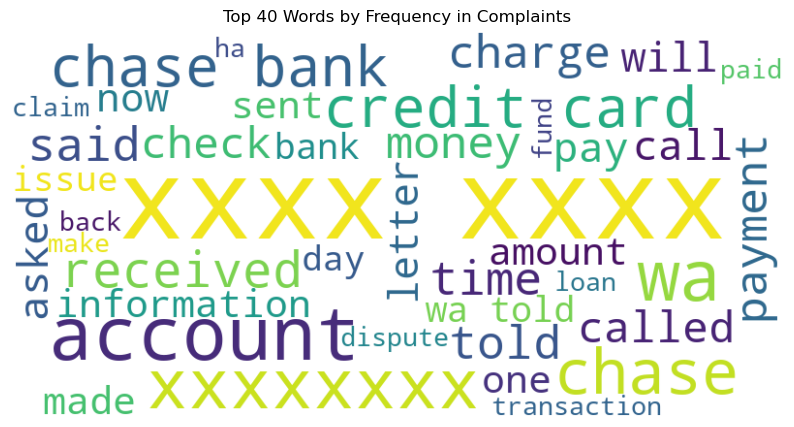

In [18]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

from wordcloud import WordCloud

all_complaints = ' '.join(df_clean['lemmatized_complaints'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=40).generate(all_complaints)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 40 Words by Frequency in Complaints')
plt.show()


In [19]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean = df_clean.drop(['complaint_POS_removed'], axis=1)
df_clean.head()

,complaint_text,lemmatized_complaints,complaint_length,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,486,morning name stop debt verification statement ...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in xxxx and wa to...,355,card agent anniversary date agent wa informati...
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on xxxx however fraudul...,224,card application identity consent service cred...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xxxx while trying to book a xxxx xxxx ticke...,1502,ticket offer ticket reward card information of...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,477,son check chase account fund chase bank accoun...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [20]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).

def get_top_n_grams(text, ngram=1, top=None):
    vectorizer = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english')
    X = vectorizer.fit_transform(text)
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]

    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    df_unigrams = pd.DataFrame(words_freq, columns=['word', 'count'])
    if top:
        return df_unigrams.head(top)
    return df_unigrams

In [21]:
#Print the top 10 words in the unigram frequency
top_10_unigrams = get_top_n_grams(df_clean['Complaint_clean'], ngram=1, top=10)
print(top_10_unigrams)

      word  count
0    chase  58908
1  account  46898
2   credit  32540
3     card  30150
4  payment  21151
5     bank  20599
6     time  16017
7      day  13171
8   charge  11971
9    money  11941


In [22]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
top_30_bigrams = get_top_n_grams(df_clean['Complaint_clean'], ngram=1, top=30)
print(top_30_bigrams)

           word  count
0         chase  58908
1       account  46898
2        credit  32540
3          card  30150
4       payment  21151
5          bank  20599
6          time  16017
7           day  13171
8        charge  11971
9         money  11941
10         loan  10765
11        check  10233
12  information   9633
13       letter   9614
14          fee   8857
15       number   8547
16  transaction   8536
17        month   8509
18         year   8379
19     customer   8117
20     mortgage   7937
21      balance   7696
22      company   7533
23      service   7475
24        phone   7473
25       report   6960
26         fund   6951
27        claim   6707
28        fraud   6516
29        email   5740


In [23]:
#Print the top 10 words in the bigram frequency
top_10_bigrams = get_top_n_grams(df_clean['Complaint_clean'], ngram=2, top=10)
print(top_10_bigrams)

               word  count
0       credit card  12835
1     credit report   3852
2     account chase   3698
3        chase bank   3505
4     chase account   3452
5      chase credit   3307
6  customer service   3054
7   account account   2818
8  checking account   2548
9      bank account   2530


In [24]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
top_30_trigrams = get_top_n_grams(df_clean['Complaint_clean'], ngram=3, top=30)
print(top_30_trigrams)

                               word  count
0                 chase credit card   2195
1               credit card account   1140
2               credit card company   1001
3                 credit card chase    886
4            chase customer service    623
5                credit card credit    576
6             inquiry credit report    552
7               account credit card    472
8                  card credit card    469
9                chase bank account    446
10            account chase account    400
11               charge credit card    381
12             credit report credit    380
13          credit reporting agency    375
14  customer service representative    351
15            account credit report    350
16              credit card payment    336
17             credit reporting act    328
18              chase account chase    309
19           checking account chase    293
20                 credit card card    285
21              credit card balance    284
22         

In [25]:
#Print the top 10 words in the trigram frequency
top_10_trigrams = get_top_n_grams(df_clean['Complaint_clean'], ngram=3, top=10)
print(top_10_trigrams)

                     word  count
0       chase credit card   2195
1     credit card account   1140
2     credit card company   1001
3       credit card chase    886
4  chase customer service    623
5      credit card credit    576
6   inquiry credit report    552
7     account credit card    472
8        card credit card    469
9      chase bank account    446


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [26]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [27]:
#All masked texts has been removed
df_clean

,complaint_text,lemmatized_complaints,complaint_length,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,486,morning name stop debt verification statement ...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in xxxx and wa to...,355,card agent anniversary date agent wa informati...
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on xxxx however fraudul...,224,card application identity consent service cred...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xxxx while trying to book a xxxx xxxx ticke...,1502,ticket offer ticket reward card information of...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,477,son check chase account fund chase bank accoun...
...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,679,chase card customer decade solicitation credit...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...,2114,credit card provider claim purchase protection...
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,2319,pay risk consumer chase bank app chase year ba...
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yr ive had chas...,2171,credit yr credit card chase freedom problem ba...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [28]:
#Write your code here to initialise the TfidfVectorizer
tdif = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [29]:
df_clean.head()

,complaint_text,lemmatized_complaints,complaint_length,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,486,morning name stop debt verification statement ...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in xxxx and wa to...,355,card agent anniversary date agent wa informati...
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on xxxx however fraudul...,224,card application identity consent service cred...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xxxx while trying to book a xxxx xxxx ticke...,1502,ticket offer ticket reward card information of...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,477,son check chase account fund chase bank accoun...


In [30]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tdif_matrix = tdif.fit_transform(df_clean['Complaint_clean'])

In [31]:
tdif_matrix.shape

(21072, 6052)

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [32]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [33]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

W = nmf_model.fit_transform(tdif_matrix)  # Document-topic matrix
H = nmf_model.components_   

In [34]:
%%time
nmf_model.fit(tdif_matrix)
len(tdif.get_feature_names_out())

CPU times: user 3.7 s, sys: 372 ms, total: 4.07 s
Wall time: 1.15 s


6052

In [35]:
#Print the Top15 words for each of the topics
feature_names = tdif.get_feature_names_out()

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        top_features = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_features]
        print(" ".join(top_words))
        print("\n")

print_top_words(nmf_model, feature_names, 15)

Topic 1:
account check bank money chase fund day deposit branch transaction checking number fee claim business


Topic 2:
card charge chase credit dispute purchase transaction service fraud merchant time fee balance company customer


Topic 3:
payment balance fee month statement day time date chase credit auto year account error mortgage


Topic 4:
credit report inquiry card account score bureau company debt reporting information identity application theft limit


Topic 5:
loan mortgage chase home modification property year letter time document rate foreclosure house sale information




In [150]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
df_new = df_clean.copy()
df_new['Topic'] = W.argmax(axis=1)

# Display the DataFrame with the assigned topics
print(df_new[['complaint_text', 'Topic']].head())

                                       complaint_text  Topic
1   Good morning my name is XXXX XXXX and I apprec...      4
2   I upgraded my XXXX XXXX card in XX/XX/2018 and...      1
10  Chase Card was reported on XX/XX/2019. However...      3
11  On XX/XX/2018, while trying to book a XXXX  XX...      3
14  my grand son give me check for {$1600.00} i de...      0


In [151]:
df_new.shape

(21072, 5)

In [152]:
df_new.head()

,complaint_text,lemmatized_complaints,complaint_length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,486,morning name stop debt verification statement ...,4
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in xxxx and wa to...,355,card agent anniversary date agent wa informati...,1
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on xxxx however fraudul...,224,card application identity consent service cred...,3
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xxxx while trying to book a xxxx xxxx ticke...,1502,ticket offer ticket reward card information of...,3
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,477,son check chase account fund chase bank accoun...,0


In [153]:
df_new.shape

(21072, 5)

In [154]:
#Print the first 5 Complaint for each of the Topics
df_new_1 = df_new.groupby('Topic').head(5)
df_new_1.sort_values('Topic')

,complaint_text,lemmatized_complaints,complaint_length,Complaint_clean,Topic
27,I opened an account with chase bank on XXXX an...,i opened an account with chase bank on xxxx an...,413,account bank code bonus term everything accoun...,0
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,477,son check chase account fund chase bank accoun...,0
17,With out notice J.P. Morgan Chase restricted m...,with out notice jp morgan chase restricted my ...,2277,notice account debit card branch customer serv...,0
24,mishandling of this account by Chase auto and ...,mishandling of this account by chase auto and ...,51,account auto,0
30,"To whom it may concern, Chase bank charged wro...",to whom it may concern chase bank charged wron...,566,concern overdraft fee alert balance unsuficent...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in xxxx and wa to...,355,card agent anniversary date agent wa informati...,1
45,I made a purchase with XXXX XXXX XXXX on XX/XX...,i made a purchase with xxxx xxxx xxxx on xxxx ...,1920,purchase amount transaction dispute case bank ...,1
40,"XXXX XXXX a sofa, love seat, table and chairs ...",xxxx xxxx a sofa love seat table and chair and...,165,sofa love seat table chair debit card bank vis...,1
21,"On XXXX XX/XX/2019, I made a {$300.00} payment...",on xxxx xxxx i made a payment to an online ret...,3541,payment retailer chase pay chase website scam ...,1
32,My chase amazon card was declined for a cateri...,my chase amazon card wa declined for a caterin...,1972,chase amazon card catering order brother funer...,1


In [155]:
df_new.shape

(21072, 5)

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [156]:
print_top_words(nmf_model, feature_names, 15)

Topic 1:
account check bank money chase fund day deposit branch transaction checking number fee claim business


Topic 2:
card charge chase credit dispute purchase transaction service fraud merchant time fee balance company customer


Topic 3:
payment balance fee month statement day time date chase credit auto year account error mortgage


Topic 4:
credit report inquiry card account score bureau company debt reporting information identity application theft limit


Topic 5:
loan mortgage chase home modification property year letter time document rate foreclosure house sale information




In [157]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: "Bank Account services",
    1: "Credit card or prepaid card",
    2: "Others",
    3: "Theft/Dispute Reporting",
    4: "Mortgage/Loan",
}
#Replace Topics with Topic Names
df_new['Topic'] = df_new['Topic'].map(Topic_names)

In [158]:
df_new.shape

(21072, 5)

In [159]:
df_new

,complaint_text,lemmatized_complaints,complaint_length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,486,morning name stop debt verification statement ...,Mortgage/Loan
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in xxxx and wa to...,355,card agent anniversary date agent wa informati...,Credit card or prepaid card
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on xxxx however fraudul...,224,card application identity consent service cred...,Theft/Dispute Reporting
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xxxx while trying to book a xxxx xxxx ticke...,1502,ticket offer ticket reward card information of...,Theft/Dispute Reporting
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,477,son check chase account fund chase bank accoun...,Bank Account services
...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,679,chase card customer decade solicitation credit...,Credit card or prepaid card
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...,2114,credit card provider claim purchase protection...,Credit card or prepaid card
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,2319,pay risk consumer chase bank app chase year ba...,Credit card or prepaid card
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yr ive had chas...,2171,credit yr credit card chase freedom problem ba...,Others


In [160]:
print(df_new.shape)
print(df_clean.shape)

(21072, 5)
(21072, 4)


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [161]:
df_new

,complaint_text,lemmatized_complaints,complaint_length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,486,morning name stop debt verification statement ...,Mortgage/Loan
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in xxxx and wa to...,355,card agent anniversary date agent wa informati...,Credit card or prepaid card
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on xxxx however fraudul...,224,card application identity consent service cred...,Theft/Dispute Reporting
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xxxx while trying to book a xxxx xxxx ticke...,1502,ticket offer ticket reward card information of...,Theft/Dispute Reporting
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,477,son check chase account fund chase bank accoun...,Bank Account services
...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,679,chase card customer decade solicitation credit...,Credit card or prepaid card
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...,2114,credit card provider claim purchase protection...,Credit card or prepaid card
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,2319,pay risk consumer chase bank app chase year ba...,Credit card or prepaid card
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yr ive had chas...,2171,credit yr credit card chase freedom problem ba...,Others


In [162]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_new[['complaint_text', 'Topic']]

In [163]:
training_data

,complaint_text,Topic
1,Good morning my name is XXXX XXXX and I apprec...,Mortgage/Loan
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card
10,Chase Card was reported on XX/XX/2019. However...,Theft/Dispute Reporting
11,"On XX/XX/2018, while trying to book a XXXX XX...",Theft/Dispute Reporting
14,my grand son give me check for {$1600.00} i de...,Bank Account services
...,...,...
78303,After being a Chase Card customer for well ove...,Credit card or prepaid card
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Credit card or prepaid card
78310,I am not familiar with XXXX pay and did not un...,Credit card or prepaid card
78311,I have had flawless credit for 30 yrs. I've ha...,Others


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [164]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

#Write your code to get the Vector count
count_vectorizer = CountVectorizer(stop_words='english')
#Transform the complaint_text column to a word vector
X_counts = count_vectorizer.fit_transform(training_data['complaint_text'])

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [165]:
training_data.shape

(21072, 2)

In [167]:
# Write your code here to build any 3 models and evaluate them using the required metrics
# Create Train-Test Split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split


# Define the features (X) and target (y)
X = X_tfidf  # TF-IDF matrix
y = training_data['Topic']  # Target column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify the shapes of the train and test sets
print("Training Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)




Training Set Shape: (16857, 29415)
Testing Set Shape: (4215, 29415)


In [169]:
# Validate original and cleaned dataset size
print("Cleaned Dataset Size:", len(df_new))
print("Original Dataset Size:", len(df))

Cleaned Dataset Size: 21072
Original Dataset Size: 21072


In [170]:
# Verify null and duplicate values count
print("Missing Values in Original Dataset:")
print(df.isnull().sum())
print("Missing Values in Cleaned Dataset:")
print(df_clean.isnull().sum())

print("Duplicate Rows in Original Dataset:", df.duplicated().sum())
print("Duplicate Rows in Cleaned Dataset:", df_clean.duplicated().sum())

Missing Values in Original Dataset:
complaint_text              0
product                     0
sub_product              2109
cleaned_text                0
lemmatized_complaints       0
dtype: int64
Missing Values in Cleaned Dataset:
complaint_text           0
lemmatized_complaints    0
complaint_length         0
Complaint_clean          0
dtype: int64
Duplicate Rows in Original Dataset: 133
Duplicate Rows in Cleaned Dataset: 142


Logistic Regression

In [171]:
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred_log_reg = log_reg.predict(X_test)

# Evaluate Logistic Regression
print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print(classification_report(y_test, y_pred_log_reg))

Logistic Regression Results:
Accuracy: 0.9285883748517201
                             precision    recall  f1-score   support

      Bank Account services       0.92      0.95      0.94      1175
Credit card or prepaid card       0.91      0.96      0.93      1232
              Mortgage/Loan       0.94      0.93      0.94       757
                     Others       0.98      0.85      0.91       502
    Theft/Dispute Reporting       0.94      0.88      0.91       549

                   accuracy                           0.93      4215
                  macro avg       0.94      0.91      0.92      4215
               weighted avg       0.93      0.93      0.93      4215



Decision Tree

In [172]:
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

# Predict on the test set
y_pred_decision_tree = decision_tree.predict(X_test)

# Evaluate Decision Tree
print("Decision Tree Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_decision_tree))
print(classification_report(y_test, y_pred_decision_tree))

Decision Tree Results:
Accuracy: 0.8128113879003559
                             precision    recall  f1-score   support

      Bank Account services       0.83      0.84      0.83      1175
Credit card or prepaid card       0.82      0.83      0.82      1232
              Mortgage/Loan       0.83      0.80      0.82       757
                     Others       0.79      0.78      0.79       502
    Theft/Dispute Reporting       0.76      0.75      0.76       549

                   accuracy                           0.81      4215
                  macro avg       0.81      0.80      0.80      4215
               weighted avg       0.81      0.81      0.81      4215



Random Forest

In [173]:
random_forest = RandomForestClassifier(random_state=42, n_estimators=100)
random_forest.fit(X_train, y_train)

# Predict on the test set
y_pred_random_forest = random_forest.predict(X_test)

# Evaluate Random Forest
print("Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_random_forest))
print(classification_report(y_test, y_pred_random_forest))

Random Forest Results:
Accuracy: 0.8322657176749704
                             precision    recall  f1-score   support

      Bank Account services       0.83      0.92      0.87      1175
Credit card or prepaid card       0.78      0.91      0.84      1232
              Mortgage/Loan       0.88      0.87      0.87       757
                     Others       0.93      0.49      0.64       502
    Theft/Dispute Reporting       0.88      0.73      0.79       549

                   accuracy                           0.83      4215
                  macro avg       0.86      0.78      0.80      4215
               weighted avg       0.84      0.83      0.83      4215



Naive Bayes

In [174]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

# Naive Bayes
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)

# Predict on the test set
y_pred_naive_bayes = naive_bayes.predict(X_test)

# Evaluate Naive Bayes
print("Naive Bayes Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_naive_bayes))
print(classification_report(y_test, y_pred_naive_bayes))

Naive Bayes Results:
Accuracy: 0.7048635824436537
                             precision    recall  f1-score   support

      Bank Account services       0.74      0.87      0.80      1175
Credit card or prepaid card       0.60      0.91      0.73      1232
              Mortgage/Loan       0.82      0.78      0.80       757
                     Others       0.92      0.09      0.17       502
    Theft/Dispute Reporting       0.93      0.35      0.50       549

                   accuracy                           0.70      4215
                  macro avg       0.80      0.60      0.60      4215
               weighted avg       0.76      0.70      0.66      4215



Logitic Regression has the highest accuracy of 92%

In [191]:
# Random complaint

random_complaint = "I am experiencing issues with my credit card. The charges are not reflecting correctly on my statement and I've been overcharged for several purchases. I need this resolved immediately as it is impacting my finances."

In [190]:
processed_text = clean_text(random_complaint)
inference_tfidf = tfidf_transformer.transform(count_vectorizer.transform([processed_text]))

# Predict the topic for the random complaint using the best model (Logistic Regression)
predicted_topic = log_reg.predict(inference_tfidf)

print("Predicted Topic for Random Complaint:", predicted_topic[0])



Predicted Topic for Random Complaint: Credit card or prepaid card
